In [170]:
from glob import glob
import pandas as pd
import numpy as np

### Create the training dataset

In [59]:
# Extract the subjects' label.
path_labels = '../data/risk_golden_truth.txt'
labels = {}
with open(path_labels, 'r') as f:
    for line in f:
        subject, label = line.split()
        labels[subject] = int(label)

In [99]:
# Create the train dataset from the subjects' posts and label.
txt_path = glob('../data/processed/*')
rows_data = []
for path in txt_path:
   with open(path, 'r+') as f:
      # Split the path, get the filename 
      # (which contains the subject) and remove '.txt'
      subject = path.split('\\')[1][:-4] 
      txt = f.read()
      rows_data.append((subject, txt, labels[subject]))

# Training dataset.
train_data = pd.DataFrame(rows_data, columns=['Subject', 'Text', 'Label'])

In [100]:
train_data

,Subject,Text,Label
0,subject1,Vulcan's ultimate landing at max range is so s...,0
1,subject100,I almost only play Marathon/Huge. I enjoy slow...,0
2,subject1006,http://imgur.com/igov5qk http://imgur.com/vHu8...,0
3,subject1008,What are the list of softwares you use for day...,0
4,subject1011,Subscribe and like will help me #128522;\nLoL\...,0
...,...,...,...
2343,subject9980,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,0
2344,subject9981,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,0
2345,subject9986,Checkout r/GoGoJoJo against the qualified immu...,0
2346,subject9990,Only took about 10 tries to post correctly lol...,0


### Preprocess the subjects' posts
Text normalization techniques:
- lowercasing 
- whitespace removal
- URL removal
- tokenization
- stopwords removal
- punctuation removal
- stemming
- lemmatization

In [139]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from spellchecker import SpellChecker

In [101]:
# Normalize all words to lowercase.
train_data["Text"] = train_data["Text"].str.lower()

In [102]:
def remove_whitespace(text):
   """ Removes all whitespaces from a given text."""
   return " ".join(text.split())

In [103]:
# Remove all whitespaces from texts.
train_data["Text"] = train_data["Text"].apply(remove_whitespace)

In [104]:
def remove_URLs(text):
   "Remove URLs from text using regular expressions."
   url_re = re.compile(r'https?://\S+|www\.\S+')
   return url_re.sub(r'', text)

In [105]:
train_data["Text"][2][:200]

'http://imgur.com/igov5qk http://imgur.com/vhu8cjn this was just a lucky run all around. i got some g'

In [106]:
# Remove URLs from texts.
train_data["Text"] = train_data["Text"].apply(remove_URLs)

In [107]:
train_data["Text"][2][:200]

'  this was just a lucky run all around. i got some good crew early and then got good system levels l'

In [109]:
# Extract tokens from texts.
train_data["Text"] = train_data["Text"].apply(lambda x: word_tokenize(x))

In [125]:
def remove_punctuation(text):
   tokenizer = RegexpTokenizer(r'\w+')
   no_punct = tokenizer.tokenize(" ".join(text))
   return no_punct

In [127]:
# Removes punctuation from texts.
train_data["Text"] = train_data["Text"].apply(remove_punctuation)

In [134]:
en_stopwords = stopwords.words('english')
def remove_stopwords(text):
   """Removes english stopwords."""
   result = []
   for token in text:
      if token not in en_stopwords:
         result.append(token)

   return result

In [135]:
# Removes stopwords from texts.
train_data["Text"] = train_data["Text"].apply(remove_stopwords)

In [137]:
def stemming(text):
   porter = PorterStemmer()
   result = []
   for word in text:
      result.append(porter.stem(word))

   return result

In [140]:
# Apply stemming to words from texts.
train_data["Text"] = train_data["Text"].apply(stemming)

In [142]:
# Save the dataset to a .csv file.
train_data.to_csv('../data/train_dataset.csv')

### Standard ML approaches:
- LinearSVC
- Logistic Regression

<AxesSubplot:>

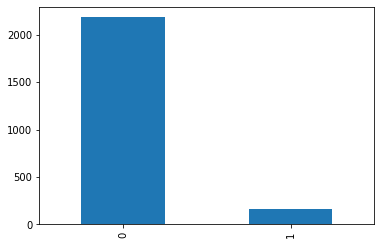

In [143]:
# Visualize the distribution of data labels.
train_data["Label"].value_counts().plot.bar()

### Baseline model - Linear SVC:

In [145]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [175]:
X = train_data["Text"].apply(" ".join)
y = train_data["Label"]
feature_extractor = CountVectorizer(lowercase=False) # bag-of-words
classifier = LinearSVC(max_iter=1000)

pipeline = Pipeline([('feature extractor', feature_extractor), ('classifier', classifier)])
cv = KFold(n_splits=4)
scores = cross_val_score(pipeline, X, y, cv = cv)

In [176]:
print("Accuracy for bag-of-words + LinearSVC:", np.mean(scores))

Accuracy for bag-of-words + LinearSVC: 0.977427597955707


### Logistic Regression:

In [173]:
classifier = LogisticRegression(max_iter=1000)
pipeline = Pipeline([('feature extractor', feature_extractor), ('classifier', classifier)])
cv = KFold(n_splits=4)
scores = cross_val_score(pipeline, X, y, cv = cv)

In [174]:
print("Accuracy for bag-of-words + LogisticRegression:", np.mean(scores))

Accuracy for bag-of-words + LogisticRegression: 0.9804088586030665
